# Import and Define Stuff
Start by gathering all of the tools and defining a number of helper functions to do geometry and Tobler function calculations.

In [36]:
import geojson
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})
import math
import numpy
import gpxpy
import gpxpy.gpx
import copy
import datetime

In [2]:
# obtain a set of GPX coordinate points from an exported GPX file.  This assumes that there is only one route saved in that file
def GetRoutePoints(filename):
    file = open(filename, 'r')
    gpx = gpxpy.parse(file)
    route = gpx.routes[0]
    points = route.points
    print(filename,'  -  ',len(points))
    return copy.copy(points)

In [3]:
# calculate the lateral distance between two (lat, long) coordinates on the surface of the earth, taking into account its curvature
# the return value is in units of meter
def GetDistance(startpoint, endpoint):
    
    # radius of the Earth in meters
    R = 6373000.0 

    # coordinates
    lat1 = math.radians(startpoint[0]) 
    lon1 = math.radians(startpoint[1]) 
    lat2 = math.radians(endpoint[0]) 
    lon2 = math.radians(endpoint[1]) 

    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

In [4]:
# encoding of Tobler's function - https://en.wikipedia.org/wiki/Tobler%27s_hiking_function
# a more precise version of naismith's rule - https://en.wikipedia.org/wiki/Naismith%27s_rule

# includes conversion factor to go from km/h to m/s of 0.2777


def GetToblerSpeed(distance, elevgain):  
    angle = (180/math.pi)*math.atan2(elevgain,distance)
    
    W = (0.2777)*6.0*math.exp(-3.5*((elevgain/distance)+0.05))
    
    if angle<=-2.86:
        W = (0.2777)*6.0*math.exp(3.5*((elevgain/distance)+0.05))
    
    return W

In [5]:
# encoding Tobler's function for a flexible choice of the three key parameters:

# all hiker’s differ to some degree and so flexibility can be taken into account in this function by varying: 
#  (1) Amplitude - the maximum speed of hiking 
#  (2) Dropoff - the difference in hiking ability on flat vs. steep terrain 
#  (3) Optimal Angle ("divpoint") - the angle of ascent (i.e. descent) at which you hike fastest.

def GetToblerSpeedFunction(distance, elevgain, divpoint, amplitude, dropoff):
    angle = (180/math.pi)*math.atan2(elevgain,distance)
    
    # this is used to tune the scale of the upper side function to match at the boundary
    slope_at_divpoint = math.tan((math.pi/180.0)*divpoint)
    val_div_down = (0.2777)*amplitude*math.exp(dropoff*(slope_at_divpoint+0.05))
    val_div_up   = (0.2777)*amplitude*math.exp(-dropoff*(slope_at_divpoint+0.05))
    scalefactor  = val_div_down/val_div_up 
     
    W = scalefactor*(0.2777)*amplitude*math.exp(-dropoff*((elevgain/distance)+0.05))
    
    if angle<=divpoint:
        W = (0.2777)*amplitude*math.exp(dropoff*((elevgain/distance)+0.05))
    
    return W

In [6]:
# Calculating the fit minimization loss for my TMB data when fitting it with a flexible Tobler function

def CalcLoss(divpoint, amplitude, dropoff, angles, speeds):
    
    loss_tot=0
    npoints = len(angles)
    
    for i in range(npoints):
        
        slope    = math.tan((math.pi/180.0)*angles[i])
        distance = 1.0
        elevgain = slope*distance
        
        
        s_predicted = GetToblerSpeedFunction(distance, elevgain, divpoint, amplitude, dropoff)
        s_observed  = speeds[i]
        
        
        
        loss = math.exp(2*s_observed)*(abs(s_predicted-s_observed)/npoints)
        
        loss_tot += loss
        
        #print("Speeds:  ",s_predicted,s_observed, loss, loss_tot)
        
    return loss_tot

In [7]:
# Given a set of GPX route points and a Tobler function, calculate the amount of time it takes along the trail, along with a number of other metrics that evaluate your hiking speed

def GetTrailMetrics(fulltrail, divpoint, amplitude, dropoff):
    ss=[]
    ds=[]
    cumds=[]
    cumlats=[]
    ts=[]
    cumts=[]
    elevs=[]

    print("TotalPoints: ",len(fulltrail))

    point_markers=[]

    for ipoint in range(len(fulltrail)-1):

        point     = fulltrail[ipoint]
        nextpoint = fulltrail[ipoint+1]

        if point.latitude==nextpoint.latitude:
            if point.longitude==nextpoint.longitude:
                print("SAME POINT - skip")
                continue

        point_markers.append(ipoint)

        #print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))
        #print('NextPoint at ({0},{1}) -> {2}'.format(nextpoint.latitude, nextpoint.longitude, nextpoint.elevation))

        distance = GetDistance((point.latitude, point.longitude), (nextpoint.latitude, nextpoint.longitude))
        elevgain = nextpoint.elevation - point.elevation

        #print("Distance: ",distance)
        #print("Elevgain: ",elevgain)

        # tobler speed for this bit
        s = GetToblerSpeedFunction(distance, elevgain, divpoint, amplitude, dropoff)
        ss.append(s)

        # total distance for this bit as the hypotenuse
        # with ghetto conversion from meters to miles
        d = (distance**2 + elevgain**2)**0.5
        ds.append(d*0.000621371)

        if ipoint==0:
            cumds.append(d*0.000621371)
        else:
            cumds.append(cumds[-1]+d*0.000621371)    

        # lateral distances
        l = distance
        if ipoint==0:
            cumlats.append(l*0.000621371)
        else:
            cumlats.append(cumlats[-1]+l*0.000621371)       

        # time for this bit
        t = d/s
        ts.append(t)

        if ipoint==0:
            cumts.append(t/(3600))
        else:
            cumts.append(cumts[-1]+t/3600)

        elevs.append(point.elevation*3.28084)

    return ss,ds,cumds,cumlats,ts,cumts,elevs

## Tobler Speed Function
A demonstration of what the Tobler function - https://en.wikipedia.org/wiki/Tobler%27s_hiking_function - looks like. 

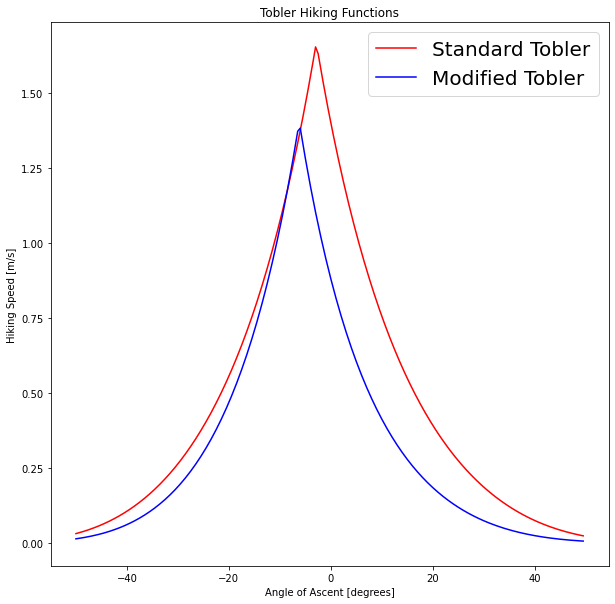

In [8]:
# standard Tobler
eval_angles = list(numpy.arange(-50,50,0.5))
ss_tobler_standard=[]
ss_tobler_custom=[]

# standard tobler parameter values
standard_divpoint = -2.86
standard_amplitude = 6.0
standard_dropoff = 3.5

for angle in eval_angles:
    
    slope    = math.tan((math.pi/180.0)*angle)
    distance = 1.0
    elevgain = slope*distance

    ss_tobler_standard.append(GetToblerSpeedFunction(distance, elevgain, standard_divpoint, standard_amplitude, standard_dropoff))
    ss_tobler_custom.append(GetToblerSpeedFunction(distance, elevgain, -6.2, 6.5, 4.3))

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(eval_angles, ss_tobler_standard, 'r',label="Standard Tobler")
plt.plot(eval_angles, ss_tobler_custom, 'b',label="Modified Tobler")
plt.xlabel("Angle of Ascent [degrees]")
plt.ylabel("Hiking Speed [m/s]")
plt.title("Tobler Hiking Functions")
plt.legend(prop={'size':20})
plt.savefig("toblerfunctions.png")
plt.show()

# Calibrating My Hiking
Obtain the GPX data from my 2020 Tour de Mont Blanc hike and use it to calibrate my Tobler function parameters


In [9]:
gpx_file = open('TMB_Full.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

Convert the sequential GPX point data to (speed, angle) points for fitting

In [10]:
speeds=[]
angles=[]

avgwindow=50

tmb = gpx.tracks[0].segments[0].points
for ipoint in range(len(tmb)-avgwindow):

    if ipoint%avgwindow!=0:
        continue
    
    point     = tmb[ipoint]
    nextpoint = tmb[ipoint+avgwindow]
    
    if point.latitude==nextpoint.latitude:
        if point.longitude==nextpoint.longitude:
            print("SAME POINT - skip")
            continue
            
    t1 = point.time
    t2 = nextpoint.time

    difference = t2-t1
    seconds_in_day = 24 * 60 * 60
    dt = divmod(difference.days * seconds_in_day + difference.seconds, 60)
    time = dt[0]*60 + dt[1]

    distance = GetDistance((point.latitude, point.longitude), (nextpoint.latitude, nextpoint.longitude))
    elevgain = nextpoint.elevation - point.elevation
    
    length = (distance**2 + elevgain**2)**0.5
    
    speed = length/time
    
    angle = (180/math.pi)*math.atan2(elevgain,distance)
    
    speeds.append(speed)
    angles.append(angle)

Plot the data and compare them to the standard Tobler function from Wikipedia

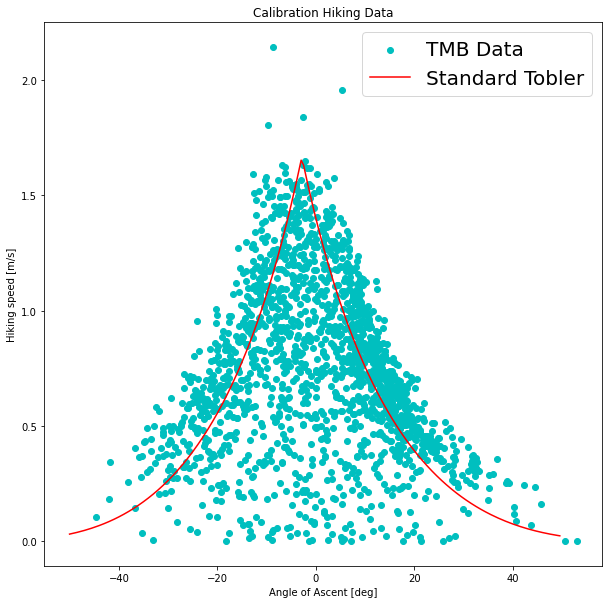

In [11]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(angles,speeds,c='c',label="TMB Data")
plt.plot(eval_angles, ss_tobler_standard, 'r', label="Standard Tobler")
plt.xlabel("Angle of Ascent [deg]")
plt.ylabel("Hiking speed [m/s]")
plt.title("Calibration Hiking Data")
plt.legend(prop={'size':20})
plt.show()

Perform the minimization fit with a flexible Tobler function by scanning many points in the space of {amplitude, dropoff, optimal angle}.

In [12]:
test_divpoints  = list(numpy.arange(-5,0,0.5))
test_amplitudes = list(numpy.arange(2,10,0.5))
test_dropoffs   = list(numpy.arange(2,5,0.2))

New Min:
3.9298568161451803
-5.0
2.0
2.0
New Min:
3.400418735847899
-5.0
2.5
2.0
New Min:
2.891909251152909
-5.0
3.0
2.0
New Min:
2.414740631159515
-5.0
3.5
2.0
New Min:
1.9883236399134039
-5.0
4.0
2.0
New Min:
1.6309629909037486
-5.0
4.5
2.0
New Min:
1.3836919786642425
-5.0
5.0
2.0
New Min:
1.2822702912503208
-5.0
5.5
2.0
New Min:
1.271723969425036
-4.5
5.5
2.0
New Min:
1.2704456765622352
-4.5
5.5
2.2
New Min:
1.2557854673999767
-4.0
5.5
2.2
New Min:
1.2547315140125272
-3.5
5.5
2.2


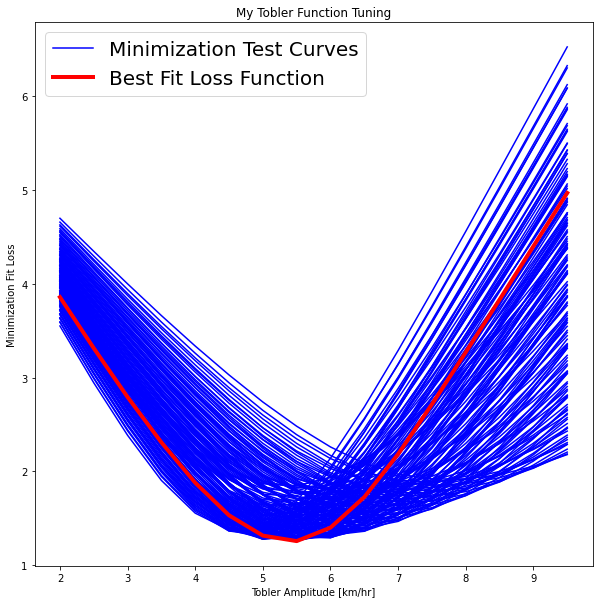

In [13]:
plt.rcParams["figure.figsize"] = (10,10)

min_loss      = 100000
min_divpoint  = 0
min_amplitude = 0
min_dropoff   = 0

for divpoint in test_divpoints:
    for dropoff in test_dropoffs:
        
        amplitudes=[]
        losses=[]
        
        for amplitude in test_amplitudes:
            loss = CalcLoss(divpoint, amplitude, dropoff, angles, speeds)
            #print("CalcLoss: ",divpoint, amplitude, dropoff, loss)
            
            if loss<min_loss:
                print("New Min:")
                min_loss      = loss
                min_divpoint  = divpoint 
                min_amplitude = amplitude
                min_dropoff   = dropoff   
                print(min_loss     )
                print(min_divpoint )
                print(min_amplitude)
                print(min_dropoff  )
            
            amplitudes.append(amplitude)
            losses.append(loss)
            
        plt.plot(amplitudes, losses, 'b')
        
        
plt.plot(amplitudes, losses, 'b',label='Minimization Test Curves')
        
# plot final minimum curve to check
amplitudes=[]
losses=[]

for amplitude in test_amplitudes:
    loss = CalcLoss(min_divpoint, amplitude, min_dropoff, angles, speeds)

    amplitudes.append(amplitude)
    losses.append(loss)

plt.plot(amplitudes, losses, c='r', linewidth=4, label='Best Fit Loss Function')
plt.xlabel("Tobler Amplitude [km/hr]")
plt.ylabel("Minimization Fit Loss")
plt.legend(prop={'size':20})
plt.title("My Tobler Function Tuning")
plt.savefig("TMBdataminimization.png")
plt.show()

In [14]:
print(min_loss)
print(min_divpoint) 
print(min_amplitude)
print(min_dropoff)  

1.2547315140125272
-3.5
5.5
2.2


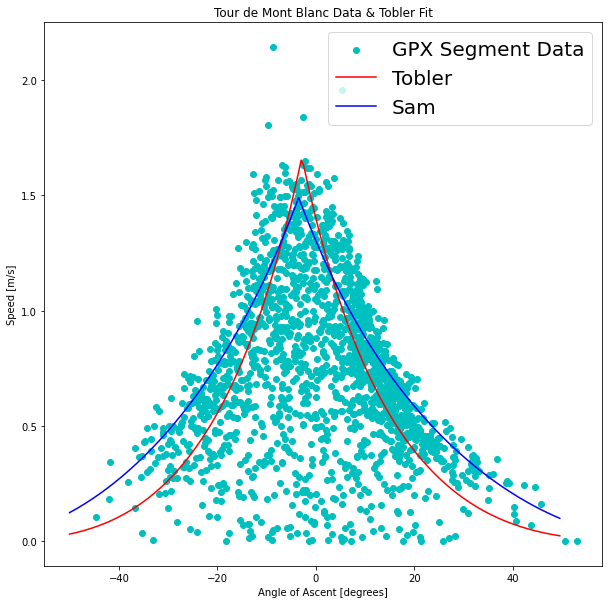

In [15]:
# standard Tobler
eval_angles = list(numpy.arange(-50,50,0.5))
ss_tobler=[]
ss_sam=[]

for angle in eval_angles:
    
    slope    = math.tan((math.pi/180.0)*angle)
    distance = 1.0
    elevgain = slope*distance


    s_tobler = GetToblerSpeedFunction(distance, elevgain, -2.86, 6.0, 3.5)
    s_sam    = GetToblerSpeedFunction(distance, elevgain, min_divpoint, min_amplitude, min_dropoff)
    
    ss_tobler.append(s_tobler)
    ss_sam.append(s_sam)
    

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(angles,speeds,c='c',label="GPX Segment Data")
plt.plot(eval_angles, ss_tobler, 'r',label="Tobler")
plt.plot(eval_angles, ss_sam, 'b',label="Sam")
plt.xlabel("Angle of Ascent [degrees]")
plt.ylabel("Speed [m/s]")
plt.title("Tour de Mont Blanc Data & Tobler Fit")
plt.legend(prop={'size':20})
plt.savefig("TMBdatafit.png")
plt.show()

# Assess the AT
Obtain the mapped out AT route data for each state that have been obtained using Gaia - https://www.gaiagps.com/datasummary/folder/4ba5000e-a940-4c8c-ab69-4b44b76b2239/?layer=GaiaTopoRasterMeters

In [16]:
georgia         =  GetRoutePoints('at-georgia.gpx')
nctennessee     =  GetRoutePoints('at-nctennessee.gpx')
virginia        =  GetRoutePoints('at-virginia.gpx')
westvirginia    =  GetRoutePoints('at-west-virginia.gpx')
maryland        =  GetRoutePoints('at-maryland.gpx')
pennsylvania    =  GetRoutePoints('at-pennsylvania.gpx')
newyork         =  GetRoutePoints('at-new-york.gpx')
connecticut     =  GetRoutePoints('at-connecticut.gpx')
massachusetts   =  GetRoutePoints('at-massachusetts.gpx')
vermont         =  GetRoutePoints('at-vermont.gpx')
newhampshire    =  GetRoutePoints('at-new-hampshire.gpx')
maine           =  GetRoutePoints('at-maine.gpx')


at-georgia.gpx   -   14222
at-nctennessee.gpx   -   34895
at-virginia.gpx   -   9481
at-west-virginia.gpx   -   1244
at-maryland.gpx   -   3215
at-pennsylvania.gpx   -   18736
at-new-york.gpx   -   3843
at-connecticut.gpx   -   2629
at-massachusetts.gpx   -   11122
at-vermont.gpx   -   6870
at-new-hampshire.gpx   -   4780
at-maine.gpx   -   13554


Concatenate all of this data into a single path for later use, while still preserving the ability to treat them as single sections.

In [17]:
print(len(georgia))
print(len(nctennessee))

StateEnds={}
StateEndsTrailDistance={}

fulltrail=copy.copy(georgia)
StateEnds["Georgia"]=len(fulltrail)

fulltrail+=nctennessee  
StateEnds["NC & Tenn"]=len(fulltrail)

fulltrail+=virginia     
StateEnds["Virginia"]=len(fulltrail)

fulltrail+=westvirginia 
StateEnds["West Virginia"]=len(fulltrail)

fulltrail+=maryland     
StateEnds["Maryland"]=len(fulltrail)

fulltrail+=pennsylvania 
StateEnds["Pennsylvania"]=len(fulltrail)

fulltrail+=newyork      
StateEnds["New York"]=len(fulltrail)

fulltrail+=connecticut  
StateEnds["Connecticut"]=len(fulltrail)

fulltrail+=massachusetts
StateEnds["Massachusetts"]=len(fulltrail)

fulltrail+=vermont      
StateEnds["Vermont"]=len(fulltrail)

fulltrail+=newhampshire 
StateEnds["New Hampshire"]=len(fulltrail)

fulltrail+=maine        
StateEnds["Maine"]=len(fulltrail)

print(len(fulltrail))

14222
34895
124591


Evaluate the hiking time and other trail metrics for the standard Tobler function

In [18]:
ss_t,ds_t,cumds_t,cumlats_t,ts_t,cumts_t,elevs_t = GetTrailMetrics(fulltrail, -3.6, 6.0, 3.5)

ss_t01,ds_t01,cumds_t01,cumlats_t01,ts_t01,cumts_t01,elevs_t01 = GetTrailMetrics(georgia       , -3.6, 6.0, 3.5)
ss_t02,ds_t02,cumds_t02,cumlats_t02,ts_t02,cumts_t02,elevs_t02 = GetTrailMetrics(nctennessee   , -3.6, 6.0, 3.5)
ss_t03,ds_t03,cumds_t03,cumlats_t03,ts_t03,cumts_t03,elevs_t03 = GetTrailMetrics(virginia      , -3.6, 6.0, 3.5)
ss_t04,ds_t04,cumds_t04,cumlats_t04,ts_t04,cumts_t04,elevs_t04 = GetTrailMetrics(westvirginia  , -3.6, 6.0, 3.5)
ss_t05,ds_t05,cumds_t05,cumlats_t05,ts_t05,cumts_t05,elevs_t05 = GetTrailMetrics(maryland      , -3.6, 6.0, 3.5)
ss_t06,ds_t06,cumds_t06,cumlats_t06,ts_t06,cumts_t06,elevs_t06 = GetTrailMetrics(pennsylvania  , -3.6, 6.0, 3.5)
ss_t07,ds_t07,cumds_t07,cumlats_t07,ts_t07,cumts_t07,elevs_t07 = GetTrailMetrics(newyork       , -3.6, 6.0, 3.5)
ss_t08,ds_t08,cumds_t08,cumlats_t08,ts_t08,cumts_t08,elevs_t08 = GetTrailMetrics(connecticut   , -3.6, 6.0, 3.5)
ss_t09,ds_t09,cumds_t09,cumlats_t09,ts_t09,cumts_t09,elevs_t09 = GetTrailMetrics(massachusetts , -3.6, 6.0, 3.5)
ss_t10,ds_t10,cumds_t10,cumlats_t10,ts_t10,cumts_t10,elevs_t10 = GetTrailMetrics(vermont       , -3.6, 6.0, 3.5)
ss_t11,ds_t11,cumds_t11,cumlats_t11,ts_t11,cumts_t11,elevs_t11 = GetTrailMetrics(newhampshire  , -3.6, 6.0, 3.5)
ss_t12,ds_t12,cumds_t12,cumlats_t12,ts_t12,cumts_t12,elevs_t12 = GetTrailMetrics(maine         , -3.6, 6.0, 3.5)

TotalPoints:  124591
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME PO

SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT

SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
TotalPoints:  34895
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POI

SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT

SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip


Evaluate the hiking time and other trail metrics for my own personal "fitted" Tobler function

In [19]:
ss_s,ds_s,cumds_s,cumlats_s,ts_s,cumts_s,elevs_s = GetTrailMetrics(fulltrail, min_divpoint, min_amplitude, min_dropoff)  

ss_s01,ds_s01,cumds_s01,cumlats_s01,ts_s01,cumts_s01,elevs_s01 = GetTrailMetrics(georgia       , min_divpoint, min_amplitude, min_dropoff)
ss_s02,ds_s02,cumds_s02,cumlats_s02,ts_s02,cumts_s02,elevs_s02 = GetTrailMetrics(nctennessee   , min_divpoint, min_amplitude, min_dropoff)
ss_s03,ds_s03,cumds_s03,cumlats_s03,ts_s03,cumts_s03,elevs_s03 = GetTrailMetrics(virginia      , min_divpoint, min_amplitude, min_dropoff)
ss_s04,ds_s04,cumds_s04,cumlats_s04,ts_s04,cumts_s04,elevs_s04 = GetTrailMetrics(westvirginia  , min_divpoint, min_amplitude, min_dropoff)
ss_s05,ds_s05,cumds_s05,cumlats_s05,ts_s05,cumts_s05,elevs_s05 = GetTrailMetrics(maryland      , min_divpoint, min_amplitude, min_dropoff)
ss_s06,ds_s06,cumds_s06,cumlats_s06,ts_s06,cumts_s06,elevs_s06 = GetTrailMetrics(pennsylvania  , min_divpoint, min_amplitude, min_dropoff)
ss_s07,ds_s07,cumds_s07,cumlats_s07,ts_s07,cumts_s07,elevs_s07 = GetTrailMetrics(newyork       , min_divpoint, min_amplitude, min_dropoff)
ss_s08,ds_s08,cumds_s08,cumlats_s08,ts_s08,cumts_s08,elevs_s08 = GetTrailMetrics(connecticut   , min_divpoint, min_amplitude, min_dropoff)
ss_s09,ds_s09,cumds_s09,cumlats_s09,ts_s09,cumts_s09,elevs_s09 = GetTrailMetrics(massachusetts , min_divpoint, min_amplitude, min_dropoff)
ss_s10,ds_s10,cumds_s10,cumlats_s10,ts_s10,cumts_s10,elevs_s10 = GetTrailMetrics(vermont       , min_divpoint, min_amplitude, min_dropoff)
ss_s11,ds_s11,cumds_s11,cumlats_s11,ts_s11,cumts_s11,elevs_s11 = GetTrailMetrics(newhampshire  , min_divpoint, min_amplitude, min_dropoff)
ss_t12,ds_s12,cumds_s12,cumlats_s12,ts_s12,cumts_s12,elevs_s12 = GetTrailMetrics(maine         , min_divpoint, min_amplitude, min_dropoff)

TotalPoints:  124591
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME PO

SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT

SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
TotalPoints:  14222
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POI

SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
TotalPoints:  18736
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POI

SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
TotalPoints:  13554
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POINT - skip
SAME POI

# Evaluation
Evaluating the analysis by plotting the AT trail data and hking speed/time evaluation

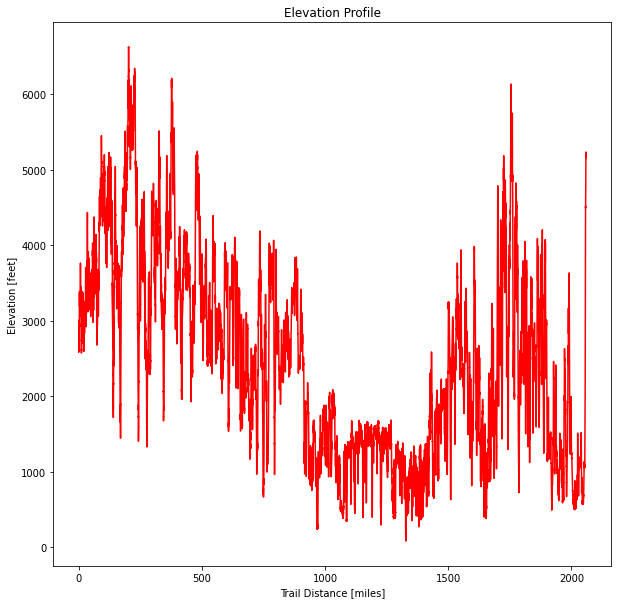

In [22]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(cumds_t, elevs_t, 'r')
plt.xlabel("Trail Distance [miles]")
plt.ylabel("Elevation [feet]")
plt.title("Elevation Profile")
plt.savefig("ATElevationProfile.png")
plt.show()

## Case Study - Georgia
Start by evaluating all of the analysis for the Georgia section of the trail

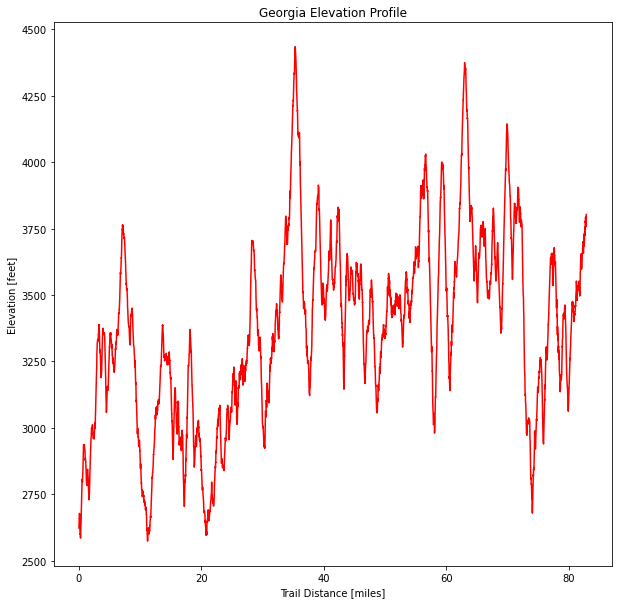

In [23]:
plt.plot(cumds_t01, elevs_t01, 'r')
plt.xlabel("Trail Distance [miles]")
plt.ylabel("Elevation [feet]")
plt.title("Georgia Elevation Profile")
plt.savefig("GeorgiaElevationProfile.png")
plt.show()

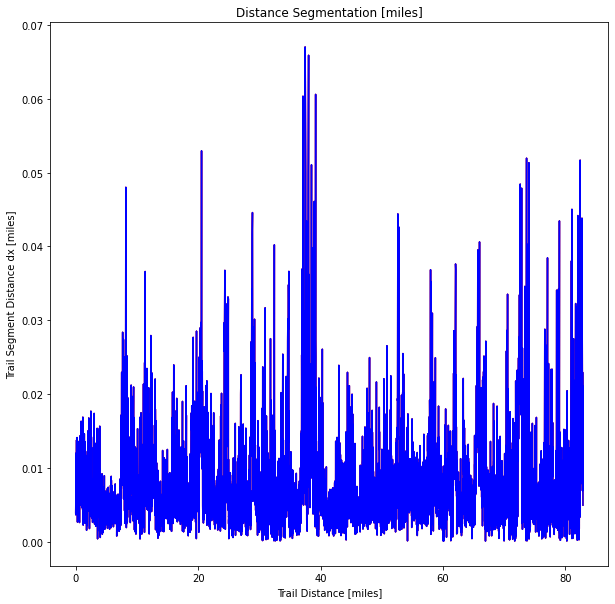

In [24]:
plt.plot(cumds_t01, ds_t01, 'r', label='Tobler')
plt.plot(cumds_t01, ds_s01, 'b', label='Sam')
plt.xlabel("Trail Distance [miles]")
plt.ylabel("Trail Segment Distance dx [miles]")
plt.title("Distance Segmentation [miles]")
plt.savefig("GeorgiaSegmentDistance.png")
plt.show()

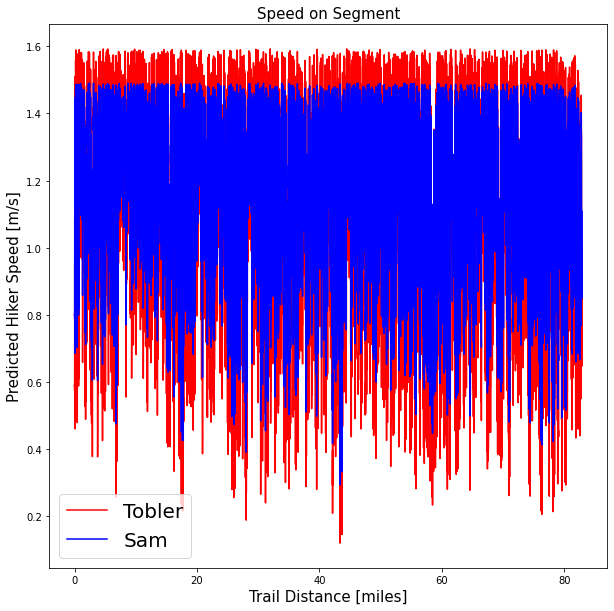

In [25]:
plt.plot(cumds_t01, ss_t01, 'r', label='Tobler')
plt.plot(cumds_t01, ss_s01, 'b', label='Sam')
plt.xlabel("Trail Distance [miles]", fontsize=15)
plt.ylabel("Predicted Hiker Speed [m/s]", fontsize=15)
plt.title("Speed on Segment", fontsize=15)
plt.legend(prop={'size':20})
plt.savefig("GeorgiaHikingSpeed.png")
plt.show()

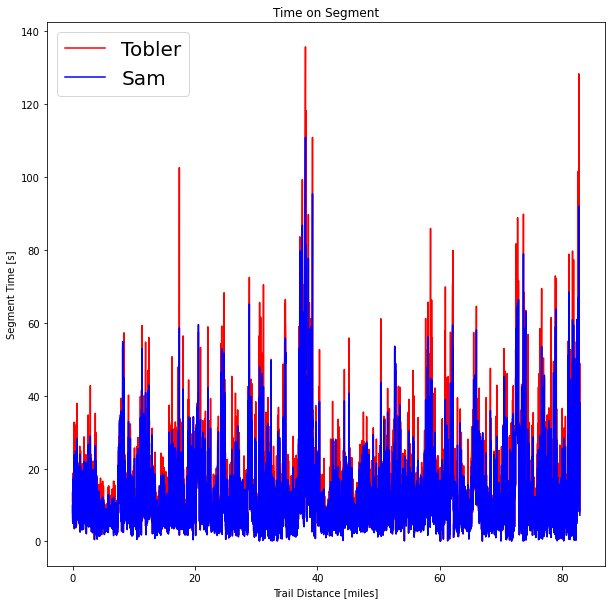

In [26]:
plt.plot(cumds_t01, ts_t01, 'r', label='Tobler')
plt.plot(cumds_t01, ts_s01, 'b', label='Sam')
plt.xlabel("Trail Distance [miles]")
plt.ylabel("Segment Time [s]")
plt.title("Time on Segment")
plt.legend(prop={'size':20})
plt.savefig("GeorgiaHikingTimeSegment.png")
plt.show()

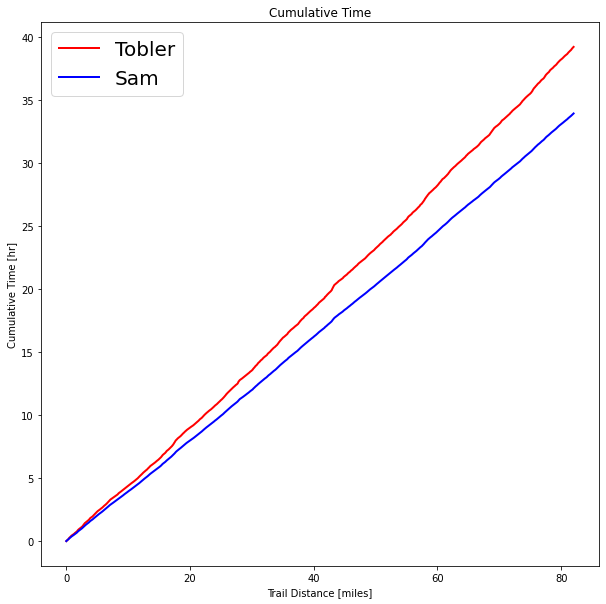

In [27]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(cumlats_t01, cumts_t01, 'r', label='Tobler', linewidth=2)
plt.plot(cumlats_t01, cumts_s01, 'b', label='Sam', linewidth=2)
plt.xlabel("Trail Distance [miles]")
plt.ylabel("Cumulative Time [hr]")
plt.title("Cumulative Time")
plt.legend(prop={'size':20})
plt.savefig("GeorgiaCumTimeGeorgia.png")
plt.show()

# ALL THE STATES!!!!!

In [28]:
# organize analyzed trail segments
AllSegments={}
AllSegments['Georgia']       ={'dis':cumlats_t01, 'elev':elevs_t01, 'tobler':cumts_t01, 'sam':cumts_s01}
AllSegments['NC & Tennessee']={'dis':cumlats_t02, 'elev':elevs_t02, 'tobler':cumts_t02, 'sam':cumts_s02}
AllSegments['Virginia']      ={'dis':cumlats_t03, 'elev':elevs_t03, 'tobler':cumts_t03, 'sam':cumts_s03}
AllSegments['West Virginia'] ={'dis':cumlats_t04, 'elev':elevs_t04, 'tobler':cumts_t04, 'sam':cumts_s04}
AllSegments['Maryland']      ={'dis':cumlats_t05, 'elev':elevs_t05, 'tobler':cumts_t05, 'sam':cumts_s05}
AllSegments['Pennsylvania']  ={'dis':cumlats_t06, 'elev':elevs_t06, 'tobler':cumts_t06, 'sam':cumts_s06}
AllSegments['New York']      ={'dis':cumlats_t07, 'elev':elevs_t07, 'tobler':cumts_t07, 'sam':cumts_s07}
AllSegments['Connecticut']   ={'dis':cumlats_t08, 'elev':elevs_t08, 'tobler':cumts_t08, 'sam':cumts_s08}
AllSegments['Massachusetts'] ={'dis':cumlats_t09, 'elev':elevs_t09, 'tobler':cumts_t09, 'sam':cumts_s09}
AllSegments['Vermont']       ={'dis':cumlats_t10, 'elev':elevs_t10, 'tobler':cumts_t10, 'sam':cumts_s10}
AllSegments['New Hampshire'] ={'dis':cumlats_t11, 'elev':elevs_t11, 'tobler':cumts_t11, 'sam':cumts_s11}
AllSegments['Maine']         ={'dis':cumlats_t12, 'elev':elevs_t12, 'tobler':cumts_t12, 'sam':cumts_s12}

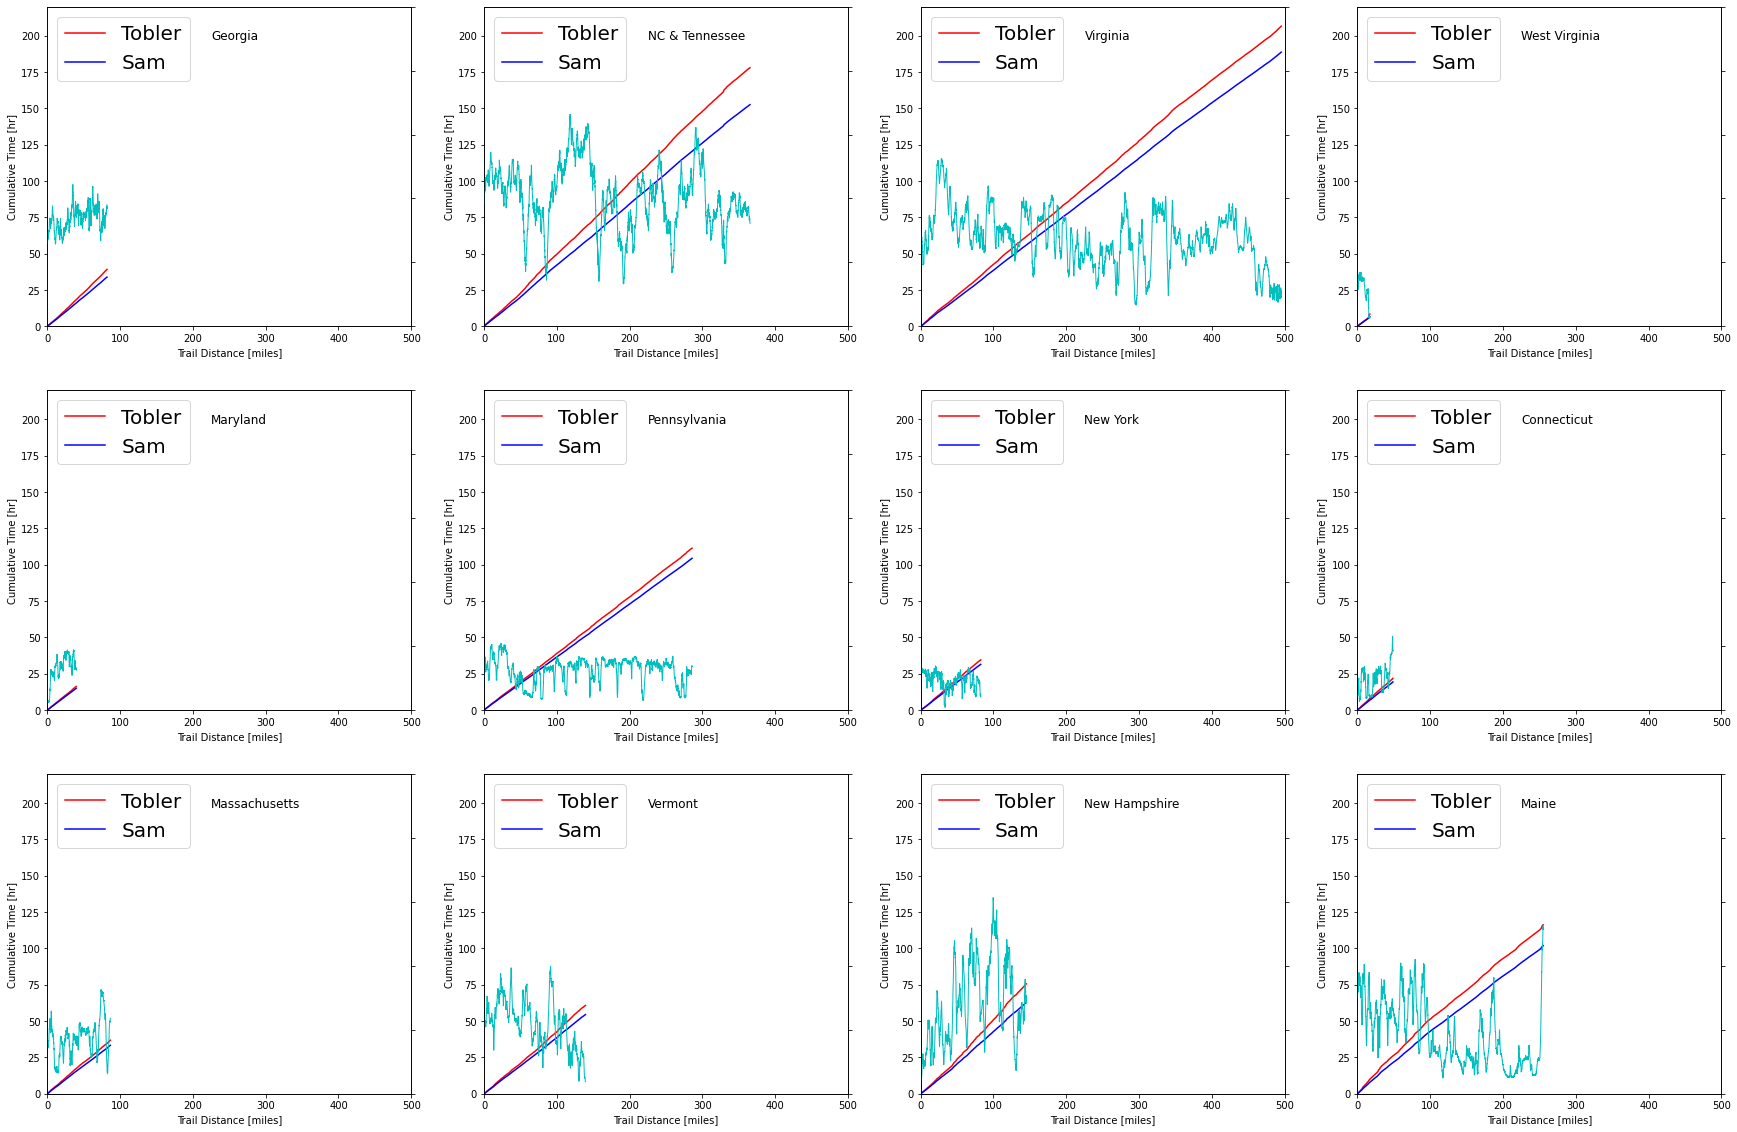

In [29]:
plt.rcParams["figure.figsize"] = (30,20)

states=[]
states.append('Georgia')
states.append('NC & Tennessee')
states.append('Virginia')
states.append('West Virginia')
states.append('Maryland')
states.append('Pennsylvania')
states.append('New York')
states.append('Connecticut')
states.append('Massachusetts')
states.append('Vermont')
states.append('New Hampshire')
states.append('Maine')

nrows=3
ncols=4
figure, axes = plt.subplots(nrows=nrows, ncols=ncols)

twin_axes={}

for row in range(nrows):
    for col in range(ncols):
        istate = (row*nrows) + col + row
        state=states[istate]
        
        #axes[row,col].plot(AllSegments[state]['dis'], AllSegments[state]['elev'], 'k',label="Elevation")
        axes[row,col].plot(AllSegments[state]['dis'], AllSegments[state]['tobler'], 'r',label="Tobler")
        axes[row,col].plot(AllSegments[state]['dis'], AllSegments[state]['sam'], 'b',label="Sam")

        axes[row,col].set_xlim([0, 500])
        axes[row,col].set_ylim([0, 220])
        axes[row,col].set_xlabel("Trail Distance [miles]")
        axes[row,col].set_ylabel("Cumulative Time [hr]")
        axes[row,col].set_title(state, loc="left", y=0.99, x=0.45, pad=-30)
        
        twin_axes[state] = axes[row,col].twinx()
        
        twin_axes[state].plot(AllSegments[state]['dis'], AllSegments[state]['elev'], 'c',label="Elevation", linewidth=1)
        twin_axes[state].set_ylabel("")
        twin_axes[state].set_yticklabels("")
        twin_axes[state].set_ylim([0, 10000])
            
        axes[row,col].legend(prop={'size':20}, loc="upper left")


plt.savefig("CumTimeAllStates.png")



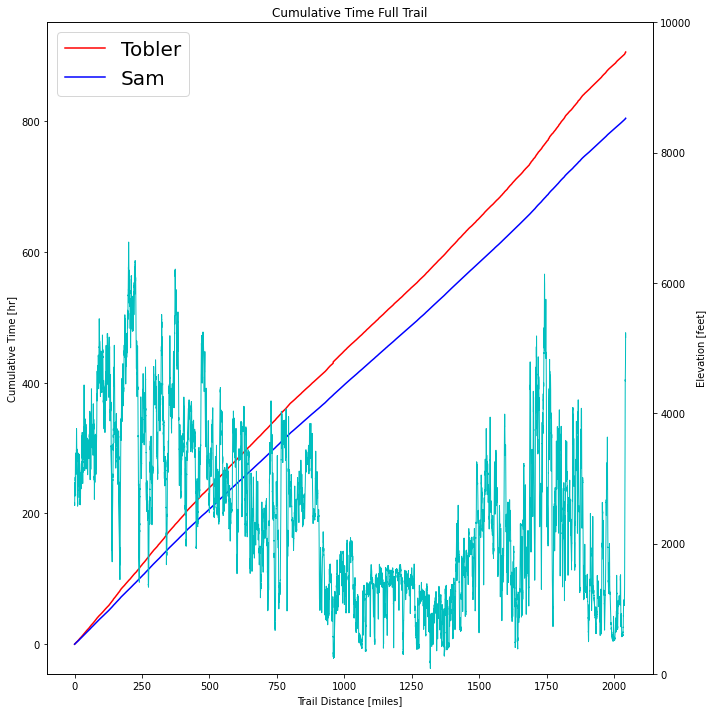

In [30]:
plt.rcParams["figure.figsize"] = (10,10)

fig, axis = plt.subplots()

axis.plot(cumlats_t, cumts_t, 'r', label='Tobler')
#axis.plot([cumlats_t[-1]], [cumts_t[-1]], 'ro')
#axis.annotate( "t="+str(round(cumts_t[-1],1))+" hr", (cumlats_t[-1]+20, cumts_t[-1]-10), c='r')

axis.plot(cumlats_t, cumts_s, 'b', label='Sam')
#axis.plot([cumlats_t[-1]], [cumts_s[-1]], 'bo')
#axis.annotate( "t="+str(round(cumts_s[-1],1))+" hr", (cumlats_s[-1]+20, cumts_s[-1]-10), c='b')

#axis.plot(cumlats_t, cumts_ex, 'g', label='Extreme')

axis.set_xlabel("Trail Distance [miles]")
axis.set_ylabel("Cumulative Time [hr]")
axis.set_title("Cumulative Time Full Trail")
axis.legend(prop={'size':20}, loc="upper left")

twin_axis = axis.twinx()
twin_axis.plot(cumlats_t, elevs_t, 'c',label="Elevation", linewidth=1)
twin_axis.set_ylabel("Elevation [feet]")
twin_axis.set_ylim([0, 10000])

fig.tight_layout()

plt.savefig("CumTimeFullTrail.png")
plt.show()

In [31]:
print(cumts_t[-1])
print(cumts_s[-1])

print(cumts_t[-1]/8)
print(cumts_s[-1]/8)

905.8840512666026
804.5313761793658
113.23550640832532
100.56642202242072


In [55]:
months={}
months[1] ="January"
months[2] ="February"
months[3] ="March"
months[4] ="April"
months[5] ="May"
months[6] ="June"
months[7] ="July"
months[8] ="August"
months[9] ="September"
months[10]="October"
months[11]="November"
months[12]="December"

startDay = datetime.date(year=2022,month=2,day=1)

totDays = 0

for state in states:
    
    NDaysState = math.ceil((AllSegments[state]['sam'][-1]/8) + 2)
    
    delta = datetime.timedelta(days=NDaysState)
    
    month = months[startDay.month]
    day   = startDay.day 
    
    startDay += delta  
    
    
    
    print("{0:20} {1:10} {2:5} {3:5} {4:5}".format(state,month,day,totDays,NDaysState))
    #print(startDay)
    
    
    totDays += NDaysState
    
    
    
    

Georgia              February       1     0     7
NC & Tennessee       February       8     7    22
Virginia             March          2    29    26
West Virginia        March         28    55     3
Maryland             March         31    58     4
Pennsylvania         April          4    62    16
New York             April         20    78     6
Connecticut          April         26    84     5
Massachusetts        May            1    89     7
Vermont              May            8    96     9
New Hampshire        May           17   105    10
Maine                May           27   115    15


In [44]:
day1 = datetime.date(year=2022,month=2,day=1)
delta = datetime.timedelta(days=2)
day2 = day1 + delta


print(day1,day2)

2022-02-01 2022-02-03


In [ ]:
Georgia              February       1     0     7
NC & Tennessee       February       8     7    22
Virginia             March          2    29    26
West Virginia        March         28    55     3
Maryland             March         31    58     4
Pennsylvania         April          4    62    16
New York             April         20    78     6
Connecticut          April         26    84     5
Massachusetts        May            1    89     7
Vermont              May            8    96     9
New Hampshire        May           17   105    10
Maine                May           27   115    15